In [18]:
import numpy as np
import recycle as re
import matplotlib.pyplot as plt
from ripser import Rips
from persim import plot_diagrams
from scipy.linalg import svdvals

In [19]:
import matplotlib.colors as mcolors

# Your specific colors
color_list = ['#0283F8', '#FFA500','#00C49A', '#FF0059']
# Create a ListedColormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("CustomColormap", color_list)

colors = {
    "red":'#FF0059',
    "blue":'#0283F8',
    "green":'#00C49A',
    "orange":'#FFA500',
    "purple":'#5751d0'
}

In [20]:
fx = np.loadtxt("data/enso/enso_idealised_kappa-1.4_anoms.txt")
#truncate:
x = np.arange(len(fx))


# ENSO 14

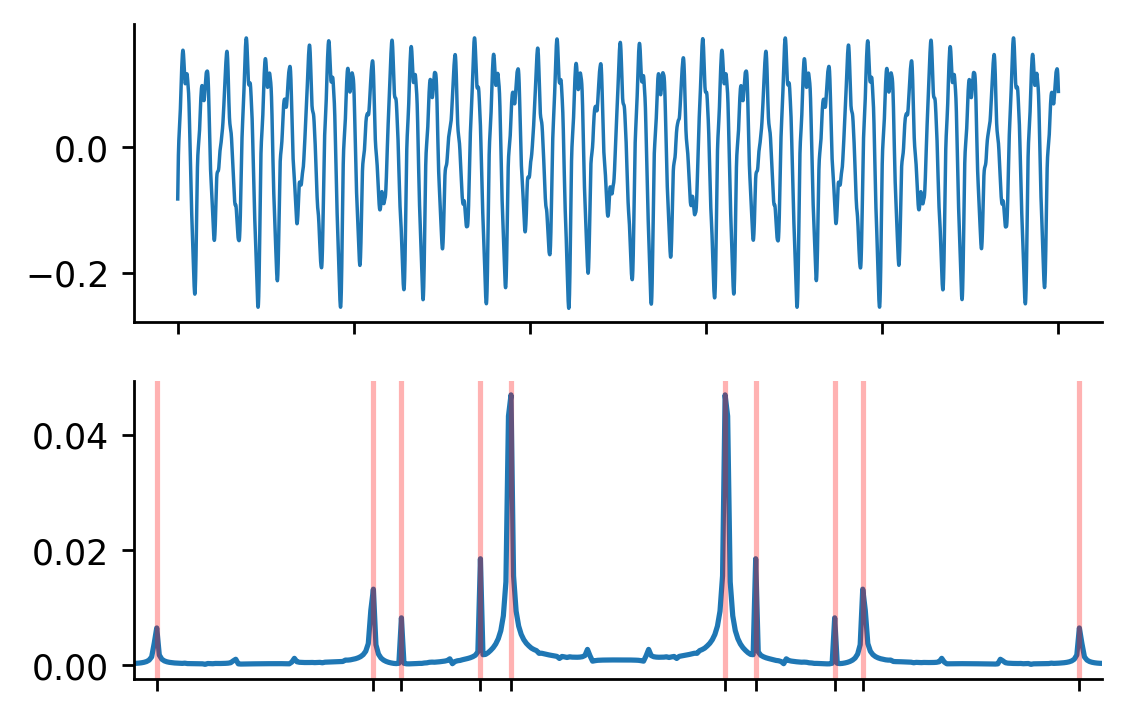

In [21]:
mosaic = """
A
B
"""

freqs, coefs, peaks = re.timeseries.find_frequency_peaks(
    fx, x, min_height=0.005, distance=10, width=1
)
fig, ax = plt.subplot_mosaic(mosaic, figsize=(5, 3.4), dpi=250)
ax["A"].plot(x, fx,linewidth=1)
ax["A"].spines[["top","right"]].set_visible(False)
ax["A"].set_xticklabels([])
re.timeseries.plot_frequency_peaks(freqs, coefs, peaks, ax["B"])
support = np.abs(freqs[np.abs(coefs)>0.005])
ax['B'].set_xticks(freqs[peaks],[""]*len(freqs[peaks])) #dont show numbers
ax['B'].set_xlim(-np.max(support)*1.05,np.max(support)*1.05)
#plt.savefig("Figures/example_enso14_signal.png",bbox_inches='tight')
plt.show()

# delays
rate = len(fx)/np.max(x)
delays = np.arange(1,400)
average_orth = [re.timeseries.gamma_value(tau, freqs[peaks]) for tau in delays]
min_delay = delays[np.argmin(average_orth)]
delay = int(min_delay // rate)


vandermond = re.timeseries.omega_matrix(min_delay, freqs[peaks])
sigma = svdvals(vandermond)
f_approx = re.timeseries.reconstruct_signal(coefs, peaks)
diff = np.abs(fx - f_approx)
lower_bound = np.sqrt(3) * np.max(np.abs(coefs[peaks])) * np.min(sigma) - np.sqrt(
    np.sum(peaks) + 1
) * np.max(diff)

# embedding
embedding = re.timeseries.time_delay_embedding(fx, dimension=np.sum(peaks), delay=delay)
bad_embedding = re.timeseries.time_delay_embedding(fx, dimension=np.sum(peaks), delay=10)


In [51]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from matplotlib.tri import Triangulation
import utils
from importlib import reload
utils = reload(utils)


def higher_embedding_plot(embedding, ax,cycles = None,cmap=None,view=(20,20),grid=True):
    # Clear any existing content on the axis
    ax.clear()
    # Ensure it's a 3D axis
    if not hasattr(ax, 'get_zlim'):
        raise ValueError("Axis must be a 3D axis")
    # Perform PCA
    pca = PCA(n_components=3).fit_transform(embedding)
    # Scatter plot
    ax.plot(pca[:,0], pca[:,1], pca[:,2], alpha=1,linewidth=0.5,linestyle="--",color="gray")
    #ax.scatter(pca[:,0], pca[:,1], pca[:,2],marker='.',s=1,alpha=0.9,color="gray")
    ax.view_init(*view)
    
    # Remove tick labels
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.set_ticklabels([])
    if cycles:
        for color,min_cycle in zip(cmap,cycles):
            for edge in list(min_cycle):
                ax.plot(*zip(pca[edge[0]], pca[edge[1]]), "-", color=colors[color], alpha=0.9,linewidth=2,marker='.',markersize=1,zorder=2)
    # Set axis limits
    ax.grid(grid)
    ax.set_xlim(-0.35,0.35);ax.set_ylim(-0.35,0.35);ax.set_zlim(-0.35,0.35)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = 1000, verbose=True)


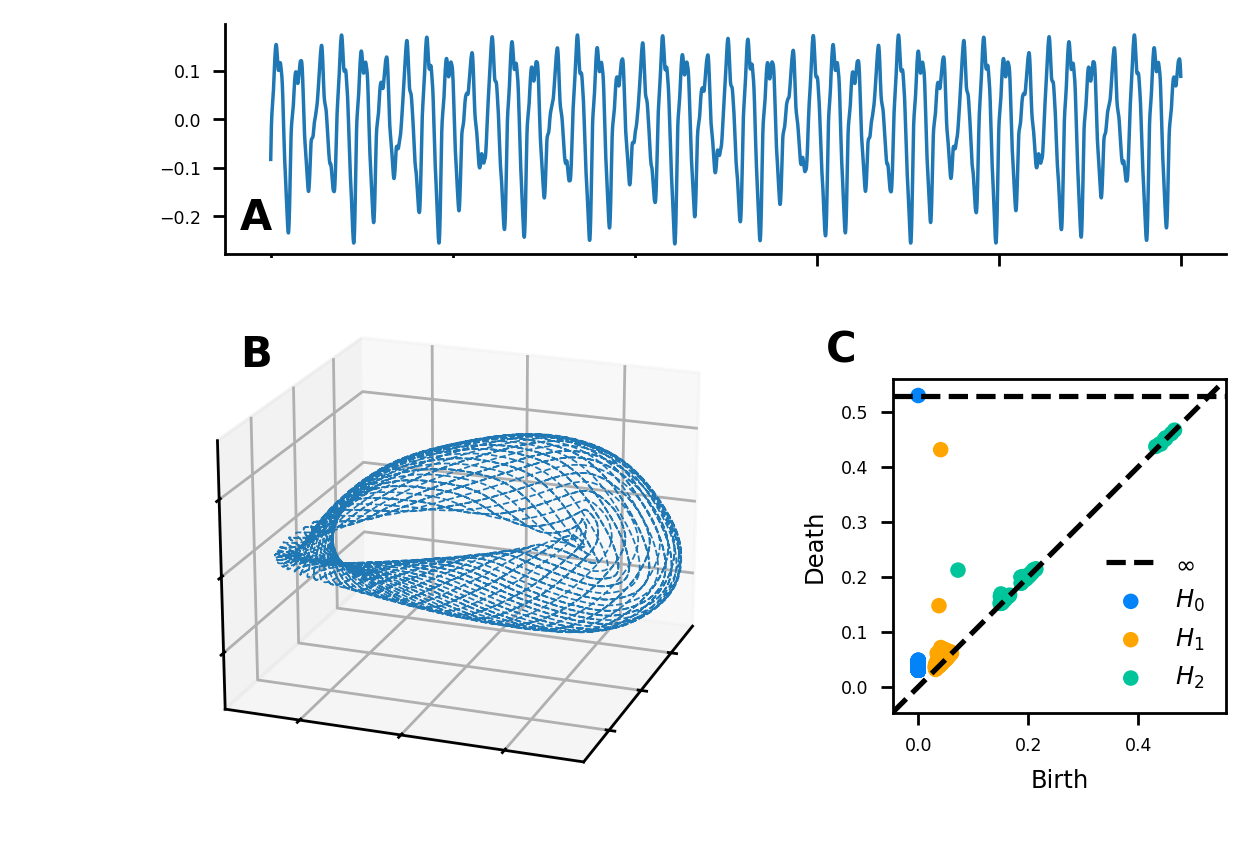

In [23]:
# Create figure with 3D subplots
fig = plt.figure(figsize=(6.2, 4.2),dpi=250)

# Create 3D subplots
gs = fig.add_gridspec(
    2, 3, 
    height_ratios=[1, 2.5],  # Top row 3x taller than bottom row
    width_ratios=[0.6, 2,1],   # Equal column widths
    wspace=0,            # Adjust column spacing (0.3 is default)
    hspace=0.01)
ax = fig.add_subplot(gs[0, 0])
ax.axis("off")
ax = fig.add_subplot(gs[0, 1:])
ax.tick_params(axis='both', which='major', labelsize=5)
ax.plot(x, fx,linewidth=1)
ax.spines[["top","right"]].set_visible(False)
ax.set_xticklabels([])
ax.text(0.015, 0.25, 'A', transform=ax.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")

ax_A = fig.add_subplot(gs[1, :2], projection='3d')
higher_embedding_plot(embedding, ax_A)
ax_A.text2D(0.12, 0.87, 'B', transform=ax_A.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")

MAXDIM = 2
N_PERM = 1000
rips = Rips(maxdim = MAXDIM, n_perm=N_PERM)
diags=rips.fit_transform(embedding)

ax = fig.add_subplot(gs[1, 2])
utils.plot_diagrams(diags,color_list,legend=True,ax = ax)
b_values = np.linspace(-10, 5, 15)
d_values = b_values + lower_bound
ax.plot(b_values, d_values, linestyle="--", color="gray")
ax.tick_params(axis='both', which='major', labelsize=5)
ax.text(-0.2, 1.15, 'C', transform=ax.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
#plt.savefig("Figures/example_enso14_embedding.png",bbox_inches='tight')
#plt.tight_layout()
plt.show()

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = 1000, verbose=True)


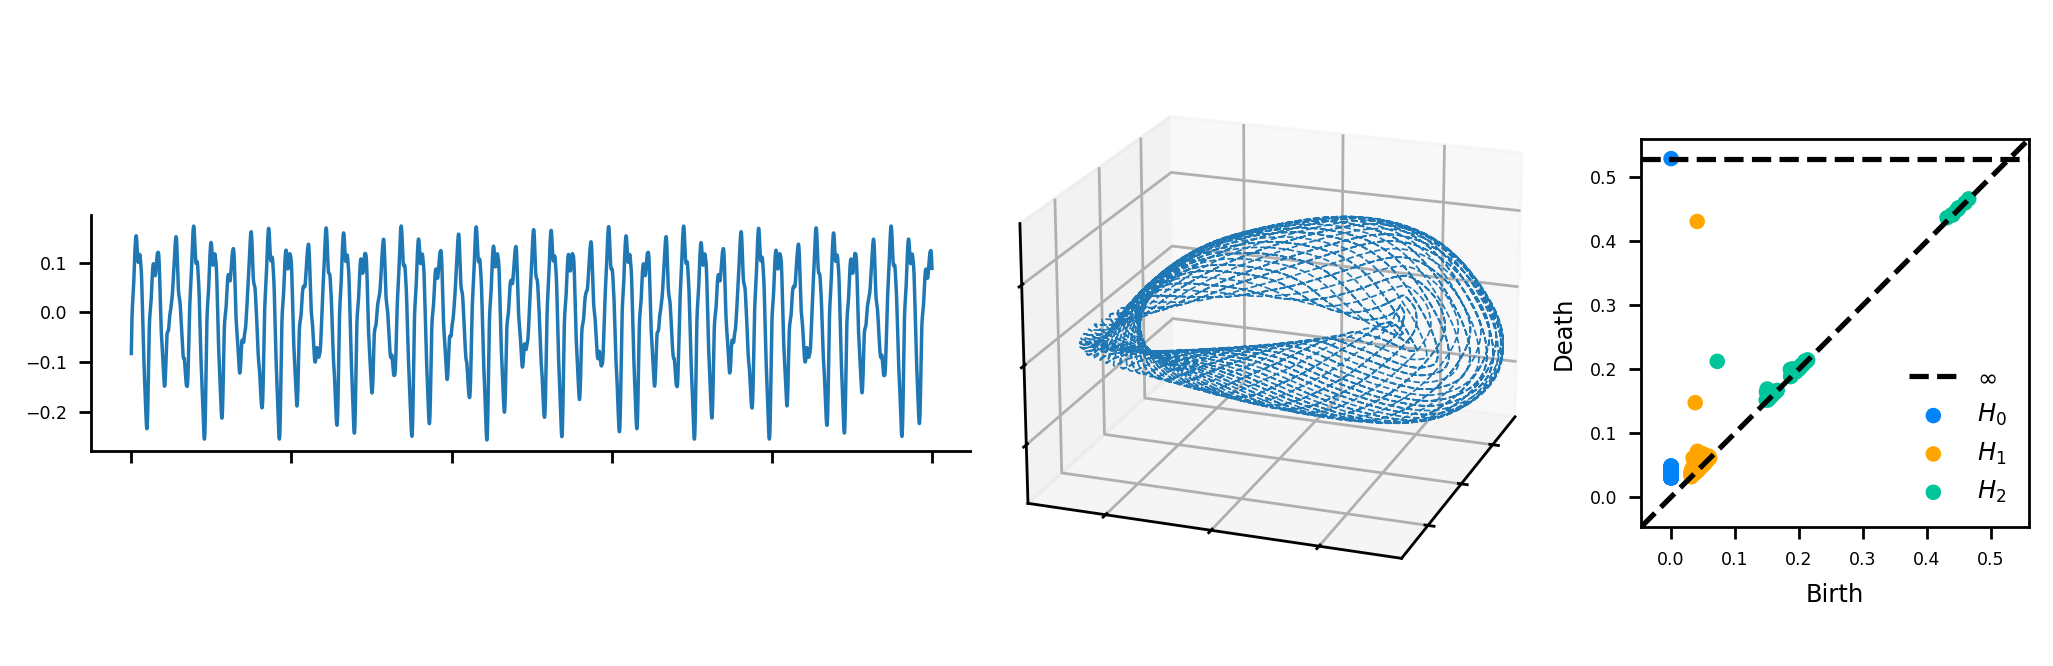

In [43]:
# Create figure with 3D subplots
fig = plt.figure(figsize=(10, 3.2),dpi=250)

# Create 3D subplots
gs = fig.add_gridspec(
    3, 4, 
    height_ratios=[0.8,1,0.8],  # Top row 3x taller than bottom row
    width_ratios=[2.5,1.7,0.2,1.1],   # Equal column widths
    wspace=0,            # Adjust column spacing (0.3 is default)
    hspace=0.01)
ax = fig.add_subplot(gs[0, 0])
ax.axis("off")
ax = fig.add_subplot(gs[-1, 0])
ax.axis("off")
ax = fig.add_subplot(gs[1, 0])
ax.tick_params(axis='both', which='major', labelsize=5)
ax.plot(x, fx,linewidth=1)
ax.spines[["top","right"]].set_visible(False)
ax.set_xticklabels([])
#ax.text(0.02, 1.3, 'A', transform=ax.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")

ax_A = fig.add_subplot(gs[:, 1], projection='3d')
higher_embedding_plot(embedding, ax_A)
#ax_A.text2D(0, 0.82, 'B', transform=ax_A.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")

MAXDIM = 2
N_PERM = 1000
rips = Rips(maxdim = MAXDIM, n_perm=N_PERM)
diags=rips.fit_transform(embedding)

ax = fig.add_subplot(gs[:, 3])
utils.plot_diagrams(diags,color_list,legend=True,ax = ax)
b_values = np.linspace(-10, 5, 15)
d_values = b_values + lower_bound
ax.plot(b_values, d_values, linestyle="--", color="gray")
ax.tick_params(axis='both', which='major', labelsize=5)
#ax.text(-0.2, 1.02, 'C', transform=ax.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
plt.savefig("Figures/example_enso14_embedding_flat.png",bbox_inches='tight')
#plt.tight_layout()
plt.show()

In [26]:
#helper function to create the length weight matrix
def edge_length_function(points):
    def edge_length(simp1, simp2):
        if simp1 == simp2:
            return np.linalg.norm(points[simp1[0]] - points[simp1[1]])
        else:
            return 0

    return edge_length


def barcode_biggest_cycle(diags):
    persistence = diags[1][:, 1] - diags[1][:, 0]
    cycle = np.argmax(persistence)
    birth, death = diags[1][cycle]
    return birth,death

In [27]:
import itertools
from collections import namedtuple
# Declaring namedtuple()

def get_double_representatives(points):
    #get maximum edge
    rips = Rips()
    diags = rips.fit_transform(points)
    _,death = barcode_biggest_cycle(diags)
    max_edge_length = death*1.01
    dimension = 2
    max_edge_length = death * 1.01  # give a bit of slack
    #compute Rips complex
    gudhi_complex = re.core.create_simplicial_complex(points, max_edge_length, dimension)
    
    #get 2 most persistent representatives
    Representative = namedtuple('Representative', ['cycle', 'birth', 'death'])
    boundary_map = {
        tuple(sorted(simplex)): set(
            itertools.combinations(tuple(sorted(simplex)), len(simplex) - 1)
        )
        - {tuple()}
        for simplex, _radius in gudhi_complex.get_filtration()
    }

    R = {k: v for k, v in boundary_map.items()}
    # V = { k : {k} for k in boundary_map}
    lowinv = {}  # lowinv[i]=index of column with the lowest 1 at i
    order_function = lambda s: (gudhi_complex.filtration(s), s)
    for s in sorted(R, key=order_function):
        t = lowinv.get(max(R[s], key=order_function), -1) if len(R[s]) != 0 else -1
        while t != -1:
            R[s] = R[t] ^ R[s]  # symmetric difference of t-th and s-th columns
            # V[s] = V[t]^V[s]
            t = lowinv.get(max(R[s], key=order_function), -1) if len(R[s]) != 0 else -1
        if len(R[s]) != 0:
            lowinv[max(R[s], key=order_function)] = s

    loops = [bar for bar in lowinv.items() if len(bar[0]) == 2]
    
    cycle_1,cycle_2 = sorted(loops, key=lambda bar: gudhi_complex.filtration(bar[1])-gudhi_complex.filtration(bar[0]), reverse=True)[:2] #get top 2 representatives
    rep1 = Representative(R[cycle_1[1]],
                           gudhi_complex.filtration(cycle_1[0]),
                           gudhi_complex.filtration(cycle_1[1]))
    rep2 = Representative(R[cycle_2[1]],
                           gudhi_complex.filtration(cycle_2[0]),
                           gudhi_complex.filtration(cycle_2[1]))

    reduced_boundary_base = {
        simplex
        for simplex, boundary in R.items()
        if len(simplex) == dimension + 1 and len(boundary) > 0
    }

    return rep1,rep2, boundary_map,reduced_boundary_base,gudhi_complex

def optimize_double_representatives(points,rep1,rep2,boundary_map,
                                    reduced_boundary_base,
                                    gudhi_complex,slack_factor,dimension=2,weight="distance"):
    assert slack_factor <= 1
    optimal_cycles = []
    order_function = lambda s: (gudhi_complex.filtration(s), s)
    for representative in rep1, rep2:
        birth, death = representative.birth, representative.death
        min_persistence = (death - birth) * slack_factor
        # ISOLATED
        np1_simplices = sorted(
            {
                simplex
                for simplex in reduced_boundary_base
                if gudhi_complex.filtration(simplex) <= (death - min_persistence)*1.01 #slack for rounding errors
            },
            key=order_function,
        )
        n_simplices = sorted(
            {
                tuple(sorted(simplex))
                for simplex, radius in gudhi_complex.get_filtration()
                if len(simplex) == dimension and radius <= (death - min_persistence)*1.01 #slack for rounding errors
            },
            key=order_function,
        )
        nm1_simplices = sorted(
            {
                tuple(sorted(simplex))
                for simplex, radius in gudhi_complex.get_filtration()
                if len(simplex) == dimension - 1 and radius <= (death - min_persistence)*1.01 #slack for rounding errors
            },
            key=order_function,
        )
        match weight:
            case "distance":
                W = re.core.create_weight_matrix(n_simplices, edge_length_function(points))
            case "time-mean":
                W = re.core.create_weight_matrix(n_simplices, time_adjacency_matrix(np.mean))
            case "time-vertex":
                W = vertex_time_difference(n_simplices)
            case _:
                print("Weight not recognized, optimizing L0-norm")
                W = None
                
                
        x_orig = re.core.lift_representative(representative.cycle, nm1_simplices, n_simplices)
        boundary_matrix = re.core.build_boundary_matrix(n_simplices, np1_simplices)
        #optimize each
        x_min, status, objective_value = re.core.find_minimal_homologous_cycle(
            boundary_matrix, x_orig, W, use_gurobi=True,verbose=False
        )
        min_cycle = set(
            [n_simplices[index] for index in np.argwhere(~np.isclose(x_min, 0)).flatten()]
        )  # be carefull here with values close to zero, add a tolerance parameter
        optimal_cycles.append(min_cycle)
    return optimal_cycles

def invert_subsample(tuple_list,subsample, sample):
    # Create a mapping of point values to their original indexes in embedding
    sample_map={i : int(np.isclose(sample,point).all(axis=1).nonzero()[0][0]) for i,point in enumerate(subsample)}
    # Map each tuple to embedding indexes
    embedding_tuples = [
        (sample_map[i], sample_map[j])
        for (i, j) in tuple_list
    ]
    return embedding_tuples


def plot_selection(x,fx,cycle,color,ax):
    vertex_set = {item for tup in cycle for item in tup}
    for vertex in vertex_set:
        plt.axvline(x[vertex], color=color, alpha=0.6,linewidth=1)
    
    ax.plot(x, fx,alpha=0.8,color="gray")
    ax.spines[["top", "right"]].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=5)
    plt.scatter(x[list(vertex_set)],fx[list(vertex_set)],color=color,s=20,edgecolors="white",linewidths=1,zorder=2)
    ax.set_xticklabels([])


In [28]:
points = embedding[:50000][::50] #100

In [29]:
rep1, rep2,boundary_map,reduced_boundary_base,gudhi_complex = get_double_representatives(points)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


# Time Optimization

In [30]:
def time_adjacency_matrix(norm=np.mean):
    def inner_time_adjacency_matrix(simplex_j, simplex_i):
        if are_simplices_adjacent(simplex_j, simplex_i):
            return time_weight(simplex_i, simplex_j,norm=norm)
        else:
            return 0

    return inner_time_adjacency_matrix

def time_label(simplex_i,norm):
    return norm(simplex_i)

def time_weight(simp1, simp2,norm) -> float:
    return np.abs(time_label(simp1,norm=norm) - time_label(simp2,norm=norm))

def are_simplices_adjacent(simplex1, simplex2):
    # Count common elements between the two tuples
    common_elements = set(simplex1).intersection(set(simplex2))
    # Two simplices are adjacent if they share exactly n-1 elements
    if len(common_elements) == len(simplex1) - 1:
        return 1
    return 0


In [31]:
mean_cycles = optimize_double_representatives(
    points,rep1,rep2,boundary_map,reduced_boundary_base,gudhi_complex,slack_factor=0.9,weight="time-mean"
)
mean_cycle1 = invert_subsample(mean_cycles[0],points,embedding)
mean_cycle2 = invert_subsample(mean_cycles[1],points,embedding)

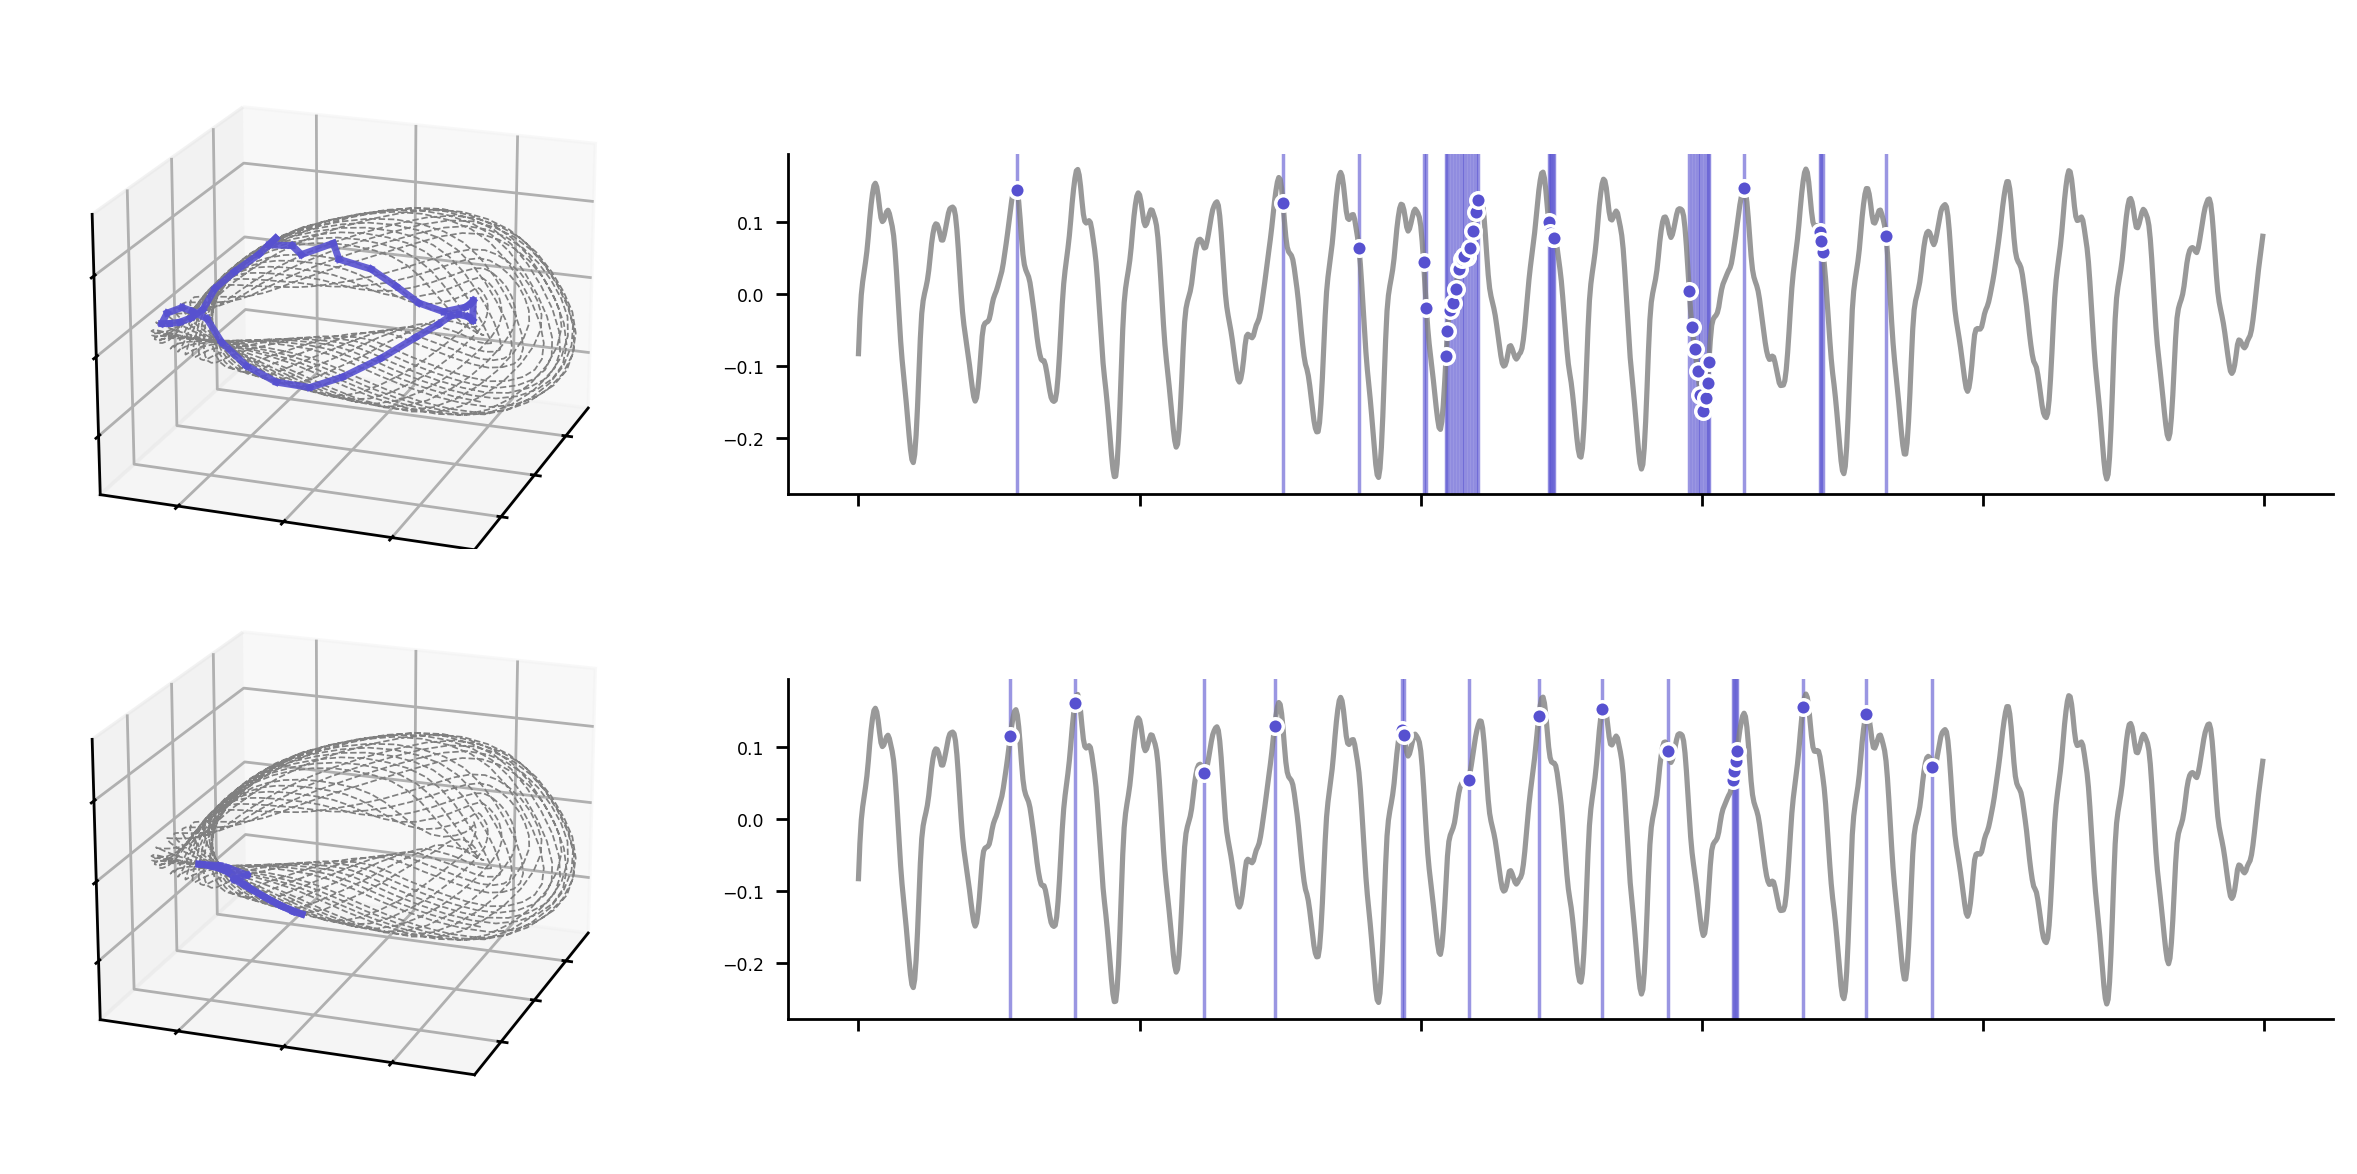

In [36]:
# Create 3D subplots
fig = plt.figure(figsize=(9.5, 4.5), dpi=250)

# Adjusting the grid specification
gs = fig.add_gridspec(
    6, 2, 
    height_ratios=[0.6,1,0.6,0.6,1,0.6],  # Equal height for both rows
    width_ratios=[0.5, 1],  # Wider right column, smaller left column
    wspace=0.05,  # Slight space between columns (you can adjust this)
    hspace=-0.3   # Space between rows (adjust to your preference)
)

# Embedding plot (3D plot on the left)
ax_A = fig.add_subplot(gs[:3, 0], projection='3d')
higher_embedding_plot(points, ax_A,cycles=[mean_cycles[0]],cmap=["purple"],view=(20,20),grid=True)
#ax_A.text2D(0.05, 0.87, 'A', transform=ax_A.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")

ax_B = fig.add_subplot(gs[3:, 0], projection='3d')
higher_embedding_plot(points, ax_B, cycles=[mean_cycles[1]],cmap=["purple"],view=(20,20),grid=True)
#ax_B.text2D(0.05, 0.87, 'B', transform=ax_B.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")


ax = fig.add_subplot(gs[0, 1])
ax.axis("off")
ax = fig.add_subplot(gs[2, 1])
ax.axis("off")
ax = fig.add_subplot(gs[3, 1])
ax.axis("off")
ax = fig.add_subplot(gs[5, 1])
ax.axis("off")


# Example 1: First plot on the top right
ax = fig.add_subplot(gs[1, 1])
plot_selection(x[:50000][::50],fx[:50000][::50],mean_cycles[0],colors["purple"],ax)
#ax.text(0.01, 1, 'B', transform=ax.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
# Example 2: Second plot on the bottom right
ax = fig.add_subplot(gs[4, 1])
plot_selection(x[:50000][::50],fx[:50000][::50],mean_cycles[1],colors["purple"],ax)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
#ax.text(0.01, 1, 'C', transform=ax.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
plt.savefig("Figures/example_enso14_representative_mean_90.png",bbox_inches='tight')
plt.show()

In [37]:
def vertex_time_difference(
    inv_row_map,
) -> np.ndarray:
    n = len(inv_row_map)
    weight_matrix = np.zeros((n, n))

    for i in range(n):
      simplex_i = inv_row_map[i]
      weight_matrix[i,i] = np.abs(simplex_i[0]-simplex_i[1])
    return weight_matrix

In [38]:
time_cycles = optimize_double_representatives(
    points,rep1,rep2,boundary_map,reduced_boundary_base,gudhi_complex,slack_factor=0.9,weight="time-vertex"
)
time_cycle1 = invert_subsample(time_cycles[0],points,embedding)
time_cycle2 = invert_subsample(time_cycles[1],points,embedding)

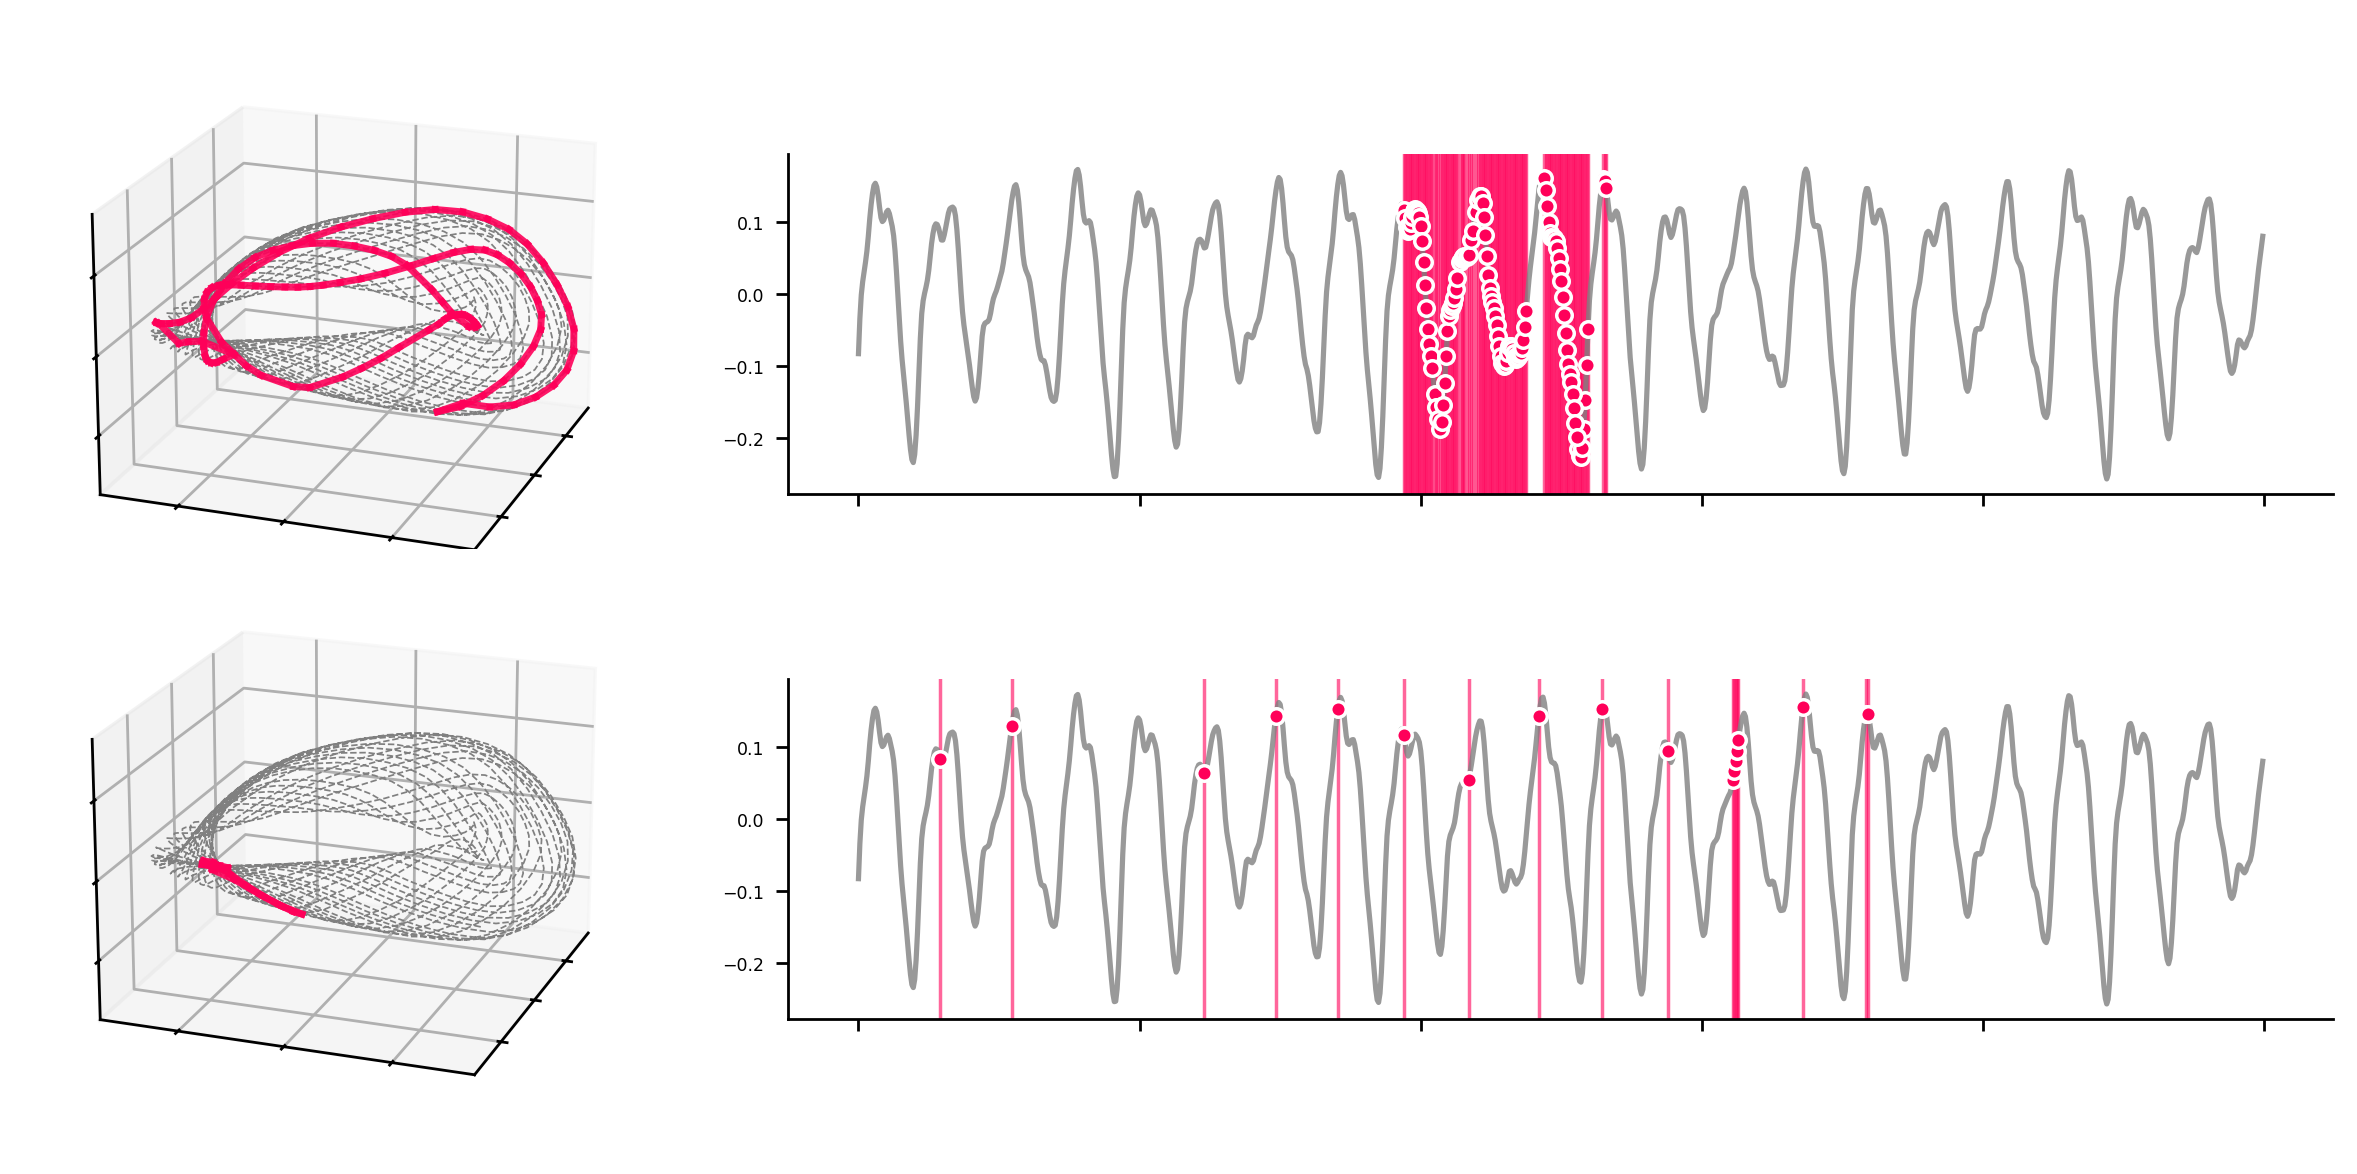

In [40]:
# Create 3D subplots
fig = plt.figure(figsize=(9.5, 4.5), dpi=250)

# Adjusting the grid specification
gs = fig.add_gridspec(
    6, 2, 
    height_ratios=[0.6,1,0.6,0.6,1,0.6],  # Equal height for both rows
    width_ratios=[0.5, 1],  # Wider right column, smaller left column
    wspace=0.05,  # Slight space between columns (you can adjust this)
    hspace=-0.3   # Space between rows (adjust to your preference)
)

# Embedding plot (3D plot on the left)
ax_A = fig.add_subplot(gs[:3, 0], projection='3d')
higher_embedding_plot(points, ax_A,cycles=[time_cycles[0]],cmap=["red"],view=(20,20))
#ax_A.text2D(0.05, 0.87, 'A', transform=ax_A.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")

ax_B = fig.add_subplot(gs[3:, 0], projection='3d')
higher_embedding_plot(points, ax_B, cycles=[time_cycles[1]],cmap=["red"],view=(20,20))
#ax_B.text2D(0.05, 0.87, 'B', transform=ax_B.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")


ax = fig.add_subplot(gs[0, 1])
ax.axis("off")
ax = fig.add_subplot(gs[2, 1])
ax.axis("off")
ax = fig.add_subplot(gs[3, 1])
ax.axis("off")
ax = fig.add_subplot(gs[5, 1])
ax.axis("off")


# Example 1: First plot on the top right
ax = fig.add_subplot(gs[1, 1])
plot_selection(x[:50000][::50],fx[:50000][::50],time_cycles[0],colors["red"],ax)
#ax.text(0.01, 1, 'B', transform=ax.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
# Example 2: Second plot on the bottom right
ax = fig.add_subplot(gs[4, 1])
plot_selection(x[:50000][::50],fx[:50000][::50],time_cycles[1],colors["red"],ax)
#ax.text(0.01, 1, 'C', transform=ax.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.savefig("Figures/example_enso14_representative_vertex_90.png",bbox_inches='tight')

plt.show()

In [44]:
# Full persistence

In [45]:
full_mean_cycles = optimize_double_representatives(
    points,rep1,rep2,boundary_map,reduced_boundary_base,gudhi_complex,slack_factor=1,weight="time-mean"
)
full_mean_cycle1 = invert_subsample(full_mean_cycles[0],points,embedding)
full_mean_cycle2 = invert_subsample(full_mean_cycles[1],points,embedding)

full_time_cycles = optimize_double_representatives(
    points,rep1,rep2,boundary_map,reduced_boundary_base,gudhi_complex,slack_factor=1,weight="time-vertex"
)
full_time_cycle1 = invert_subsample(full_time_cycles[0],points,embedding)
full_time_cycle2 = invert_subsample(full_time_cycles[1],points,embedding)

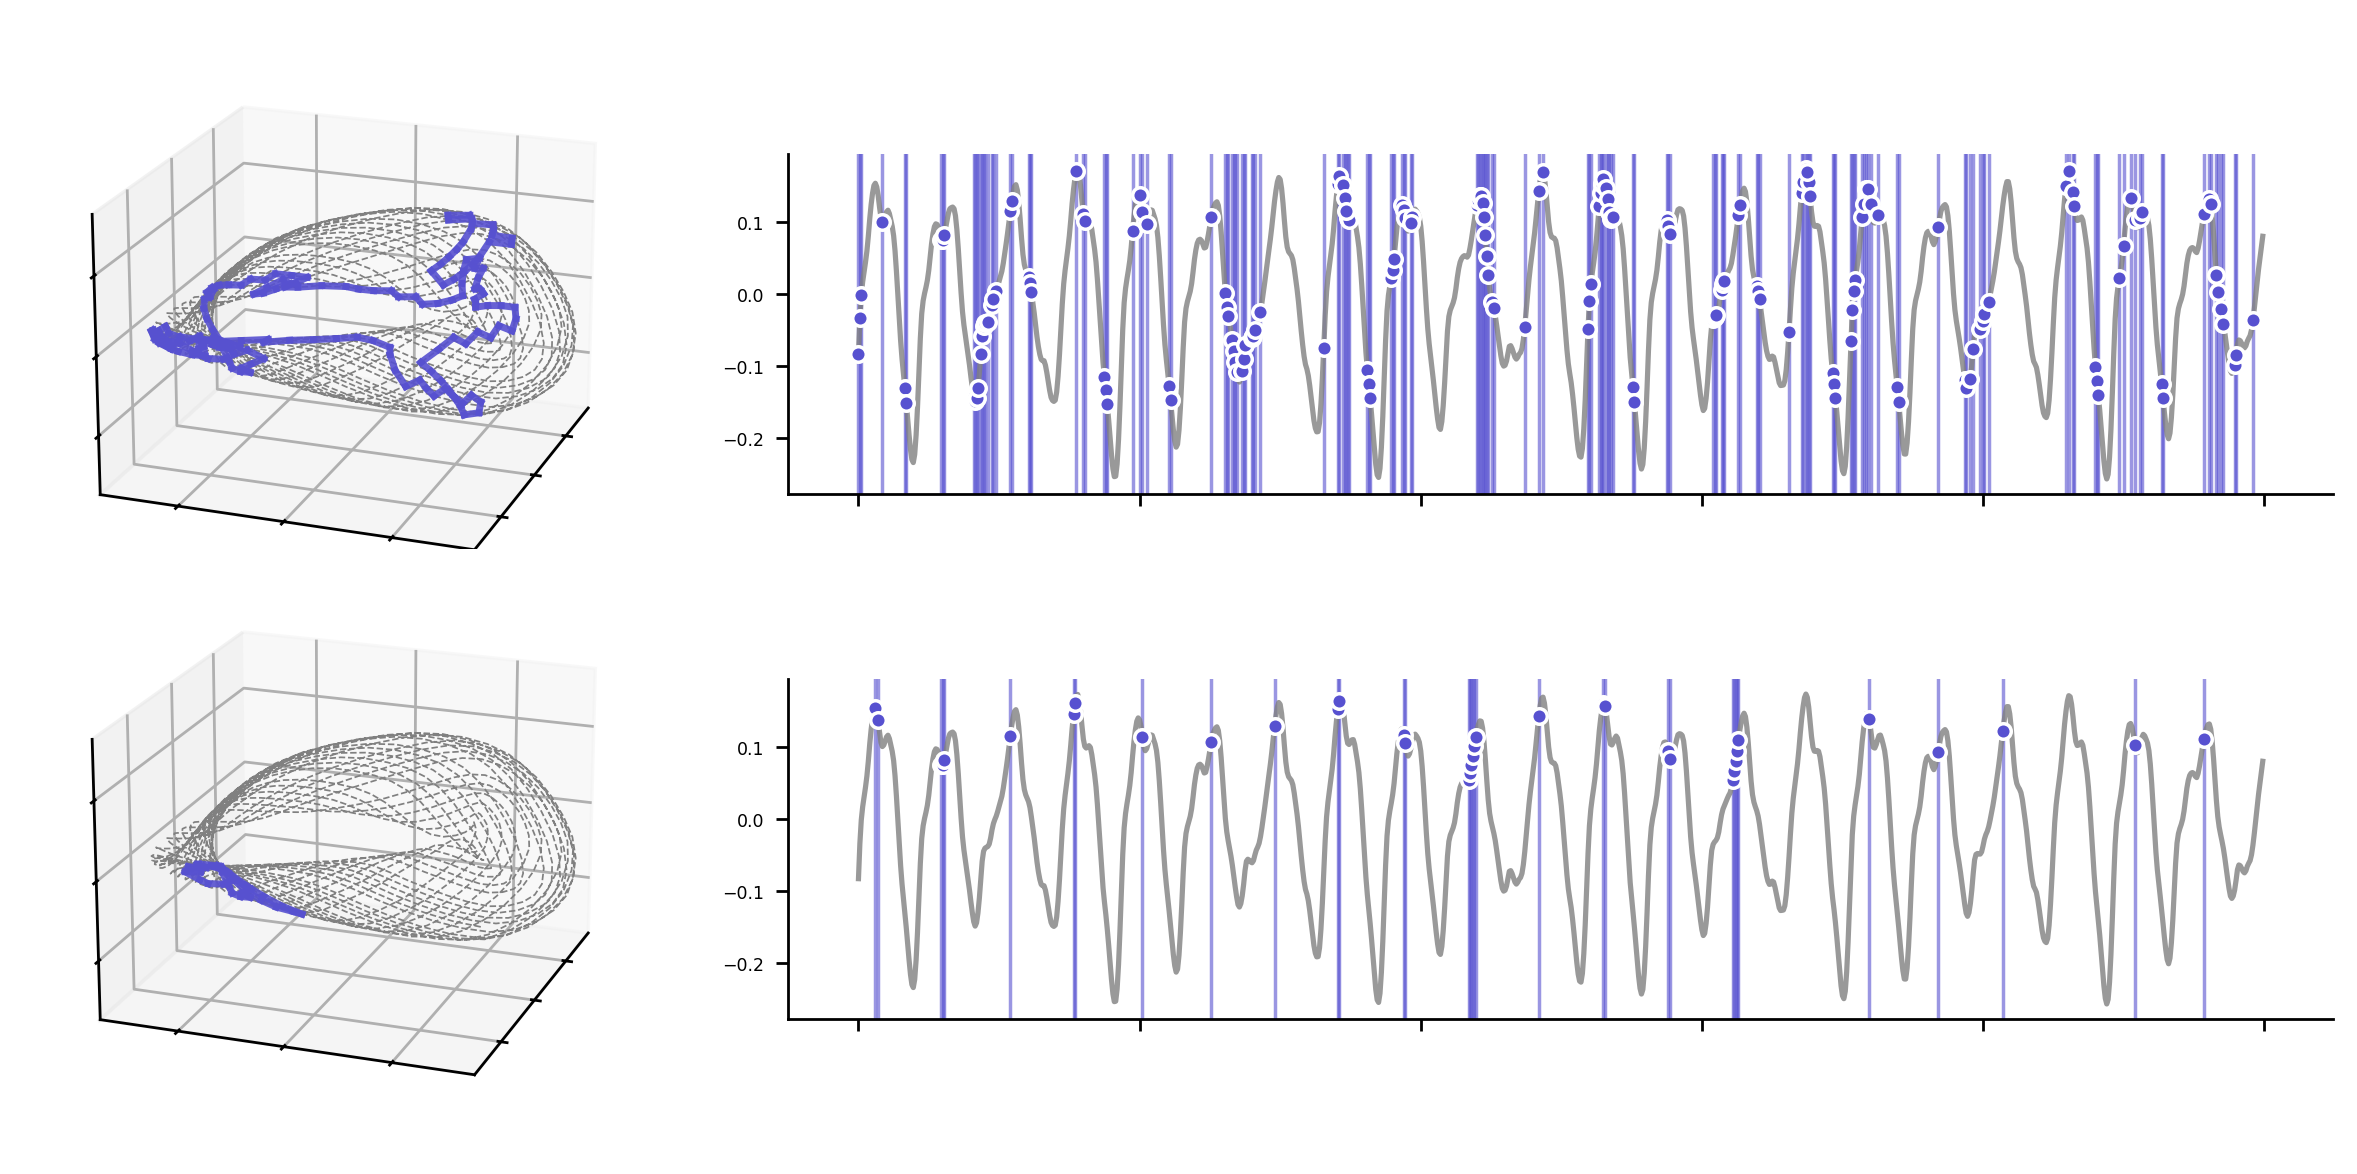

In [53]:
# Create 3D subplots
fig = plt.figure(figsize=(9.5, 4.5), dpi=250)

# Adjusting the grid specification
gs = fig.add_gridspec(
    6, 2, 
    height_ratios=[0.6,1,0.6,0.6,1,0.6],  # Equal height for both rows
    width_ratios=[0.5, 1],  # Wider right column, smaller left column
    wspace=0.05,  # Slight space between columns (you can adjust this)
    hspace=-0.3   # Space between rows (adjust to your preference)
)

# Embedding plot (3D plot on the left)
ax_A = fig.add_subplot(gs[:3, 0], projection='3d')
higher_embedding_plot(points, ax_A,cycles=[full_mean_cycles[0]],cmap=["purple"],view=(20,20),grid=True)
#ax_A.text2D(0.05, 0.87, 'A', transform=ax_A.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")

ax_B = fig.add_subplot(gs[3:, 0], projection='3d')
higher_embedding_plot(points, ax_B, cycles=[full_mean_cycles[1]],cmap=["purple"],view=(20,20),grid=True)
#ax_B.text2D(0.05, 0.87, 'B', transform=ax_B.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")


ax = fig.add_subplot(gs[0, 1])
ax.axis("off")
ax = fig.add_subplot(gs[2, 1])
ax.axis("off")
ax = fig.add_subplot(gs[3, 1])
ax.axis("off")
ax = fig.add_subplot(gs[5, 1])
ax.axis("off")


# Example 1: First plot on the top right
ax = fig.add_subplot(gs[1, 1])
plot_selection(x[:50000][::50],fx[:50000][::50],full_mean_cycles[0],colors["purple"],ax)
#ax.text(0.01, 1, 'B', transform=ax.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
# Example 2: Second plot on the bottom right
ax = fig.add_subplot(gs[4, 1])
plot_selection(x[:50000][::50],fx[:50000][::50],full_mean_cycles[1],colors["purple"],ax)
#ax.text(0.01, 1, 'C', transform=ax.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.savefig("Figures/example_enso14_representative_mean_full.png",bbox_inches='tight')
plt.show()

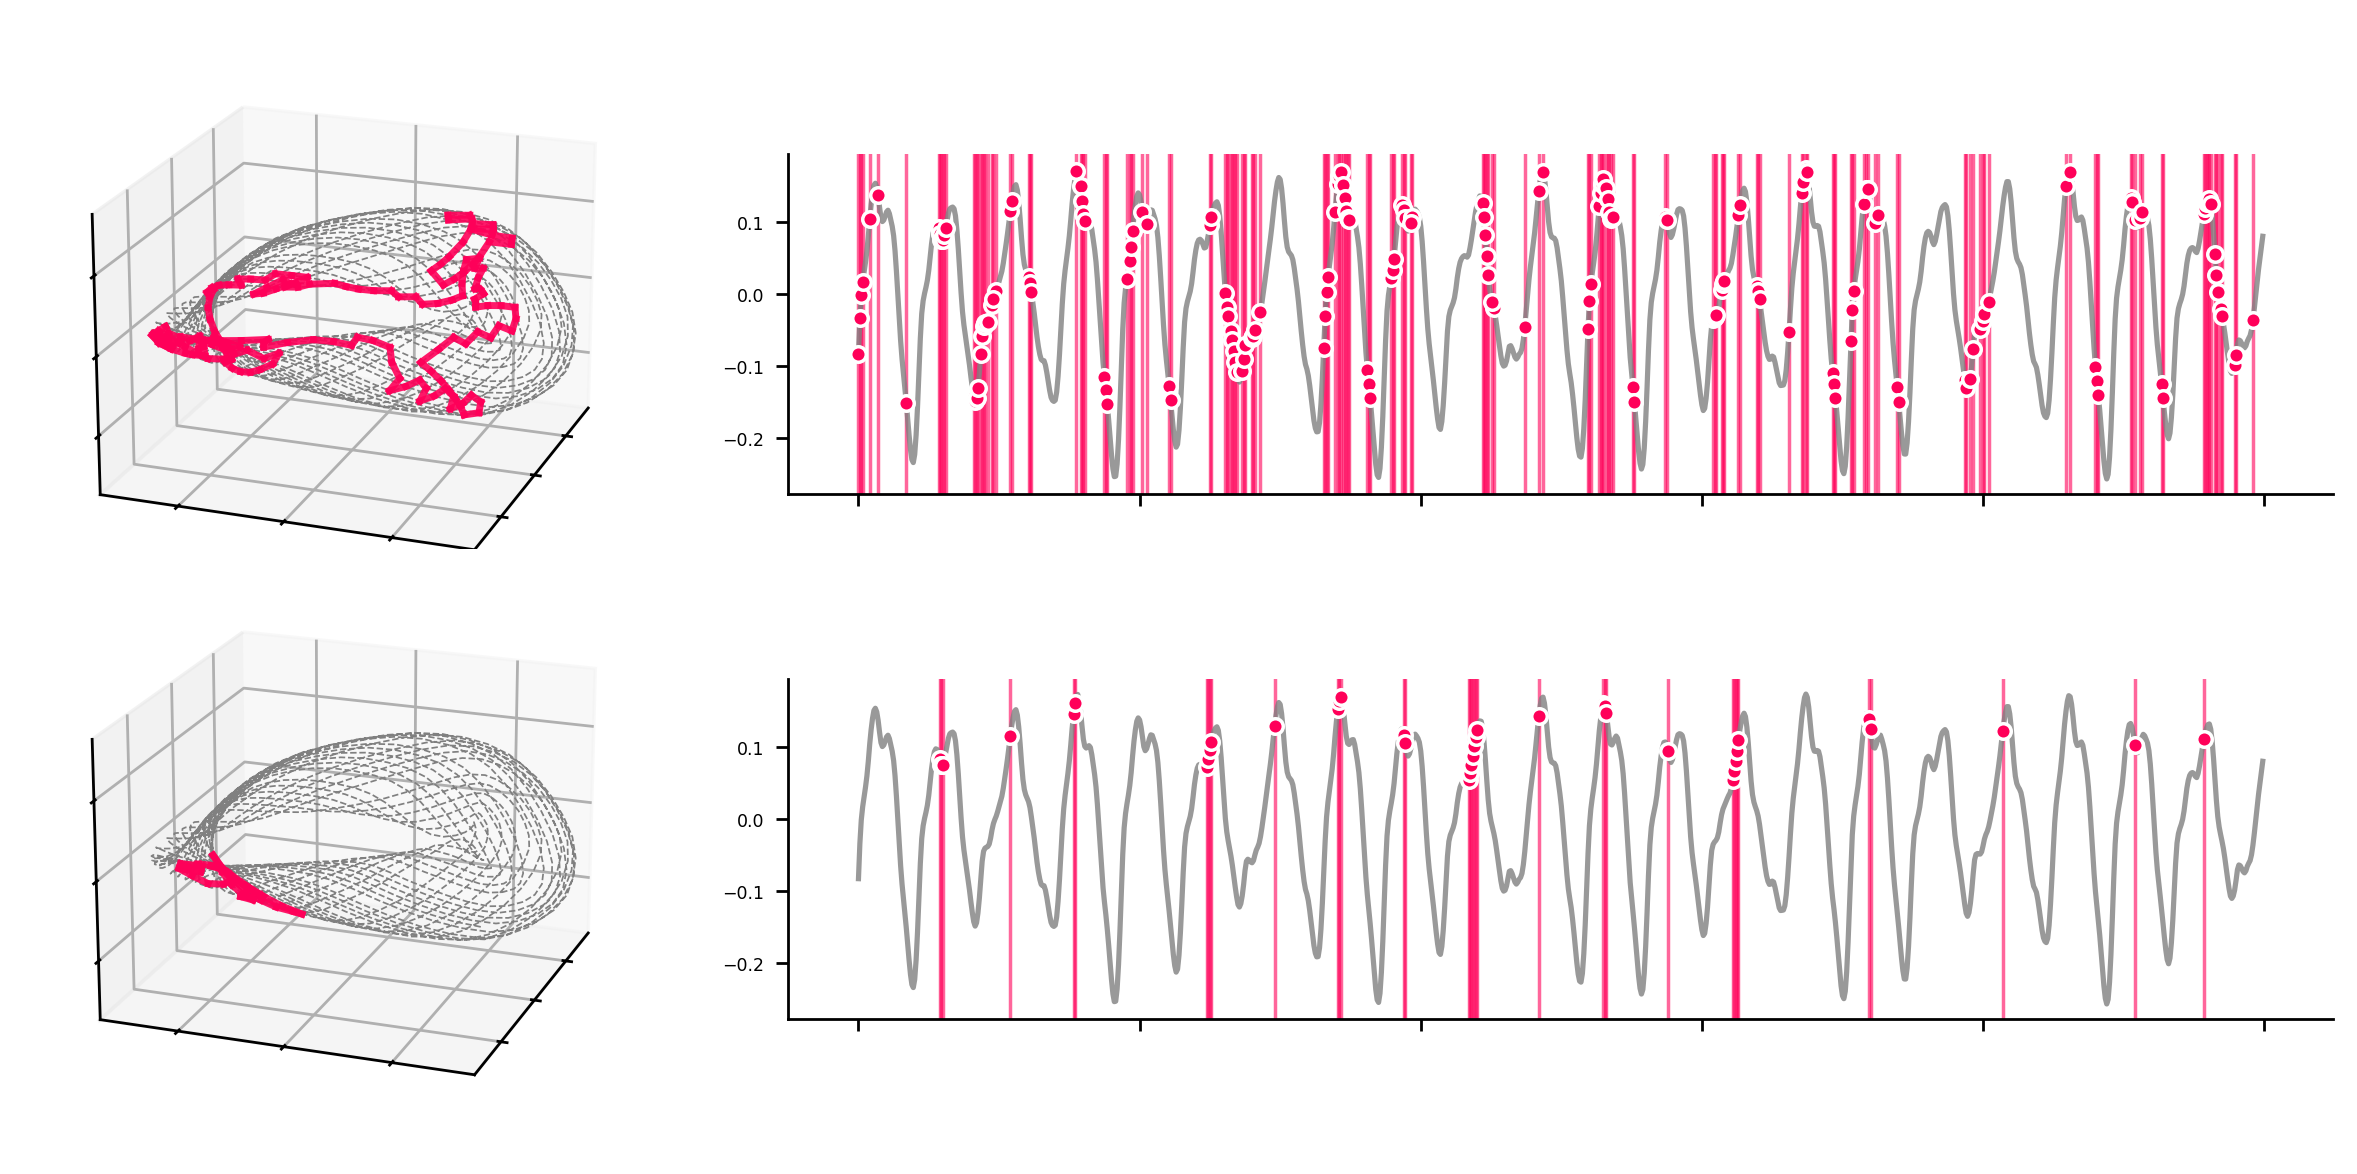

In [52]:
# Create 3D subplots
fig = plt.figure(figsize=(9.5, 4.5), dpi=250)

# Adjusting the grid specification
gs = fig.add_gridspec(
    6, 2, 
    height_ratios=[0.6,1,0.6,0.6,1,0.6],  # Equal height for both rows
    width_ratios=[0.5, 1],  # Wider right column, smaller left column
    wspace=0.05,  # Slight space between columns (you can adjust this)
    hspace=-0.3   # Space between rows (adjust to your preference)
)

# Embedding plot (3D plot on the left)
ax_A = fig.add_subplot(gs[:3, 0], projection='3d')
higher_embedding_plot(points, ax_A,cycles=[full_time_cycles[0]],cmap=["red"],view=(20,20))
#ax_A.text2D(0.05, 0.87, 'A', transform=ax_A.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")

ax_B = fig.add_subplot(gs[3:, 0], projection='3d')
higher_embedding_plot(points, ax_B, cycles=[full_time_cycles[1]],cmap=["red"],view=(20,20))
#ax_B.text2D(0.05, 0.87, 'B', transform=ax_B.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")


ax = fig.add_subplot(gs[0, 1])
ax.axis("off")
ax = fig.add_subplot(gs[2, 1])
ax.axis("off")
ax = fig.add_subplot(gs[3, 1])
ax.axis("off")
ax = fig.add_subplot(gs[5, 1])
ax.axis("off")


# Example 1: First plot on the top right
ax = fig.add_subplot(gs[1, 1])
plot_selection(x[:50000][::50],fx[:50000][::50],full_time_cycles[0],colors["red"],ax)
#ax.text(0.01, 1, 'B', transform=ax.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
# Example 2: Second plot on the bottom right
ax = fig.add_subplot(gs[4, 1])
plot_selection(x[:50000][::50],fx[:50000][::50],full_time_cycles[1],colors["red"],ax)
#ax.text(0.01, 1, 'C', transform=ax.transAxes, fontsize=12, va='top', ha='left', fontweight="bold")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.savefig("Figures/example_enso14_representative_vertex_full.png",bbox_inches='tight')
#fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.show()